In [3]:
%matplotlib inline 
%load_ext memory_profiler

import pandas as pd
import numpy as np
import os
import sys
import glob
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [4]:
# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [70]:
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

In [84]:
def do_magic(X, goi=None, t=10):
    import magic 
    import graphtools as gt
    from scipy import sparse
    
    # compute PHATE
    G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    if goi is None:
        magic_op = magic.MAGIC(t=t).fit(X=X.X, graph=G)
        X.layers['imputed'] = magic_op.transform(X.X, genes='all')
        return adata
    else:
        
        magic_op = magic.MAGIC(t=t).fit(X=X[:, goi].X, graph=G)
        Xprime = magic_op.transform(X[:, goi].X)
        return pd.DataFrame(Xprime, columns=goi, index=X.obs.index.to_list())

In [8]:
%%memit
adata_file = '/home/ngr4/project/scnd/data/processed/mouse_200614.h5ad'
adata = sc.read(adata_file)

peak memory: 11675.17 MiB, increment: 10461.47 MiB


In [5]:
%%memit

pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'
sc.settings.figdir = pfp

wt = sc.read(os.path.join(pdfp,'mouse_wt_imputed.h5ad'))
mut = sc.read(os.path.join(pdfp,'mouse_sca1_imputed.h5ad'))

peak memory: 74501.77 MiB, increment: 74307.90 MiB


In [6]:
# select just ubc
wt = wt[(wt.obs['ctype']=='Unipolar brush cell'), :]
mut = mut[(mut.obs['ctype']=='Unipolar brush cell'), :]

ubc = wt.concatenate(mut, batch_key='imp', batch_categories=['WTimp', 'SCA1imp'])

del wt, mut

# re-run to avoid batch effects
sc.tl.pca(ubc)

In [9]:
adata = adata[(adata.obs['ctype']=='Unipolar brush cell'), :] 


In [10]:
sc.tl.pca(adata)

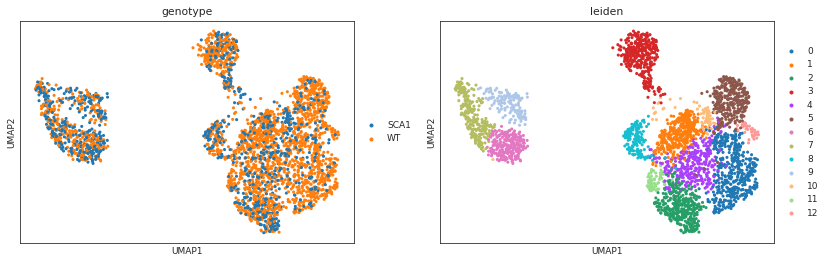

In [11]:
sc.external.pp.bbknn(adata, neighbors_within_batch=(30 // len(adata.obs['batch'].unique())), n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['genotype', 'leiden'])

In [17]:
print('OFF proportion: {:.2f}'.format(adata.obs.loc[adata.obs['leiden'].astype(str).isin([str(i) for i in [5, 6, 9]]), :].shape[0]/adata.shape[0]))

OFF proportion: 0.23


In [62]:
(100 // len(ubc.obs['batch'].unique()))

3

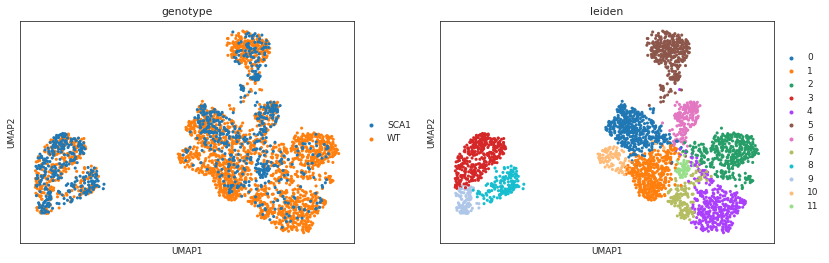

In [76]:
sc.external.pp.bbknn(ubc, neighbors_within_batch=(100 // len(ubc.obs['batch'].unique())), n_pcs=50)
# sc.pp.neighbors(ubc, n_neighbors=15, n_pcs=50)
sc.tl.umap(ubc)
sc.tl.leiden(ubc)
sc.pl.umap(ubc, color=['genotype', 'leiden'])

In [16]:
print('OFF proportion: {:.2f}'.format(ubc.obs.loc[ubc.obs['leiden'].astype(str).isin([str(i) for i in [6,7,9]]), :].shape[0]/ubc.shape[0]))

OFF proportion: 0.20


In [65]:
# annotate the clusters
ubc.obs['ubc_subtype'] = 'None'
ubc.obs.loc[ubc.obs['leiden'].astype(str).isin([str(i) for i in [3,8,9]]), 'ubc_subtype'] = 'UBC'
ubc.obs.loc[ubc.obs['ubc_subtype']=='None', 'ubc_subtype'] = 'DCN'

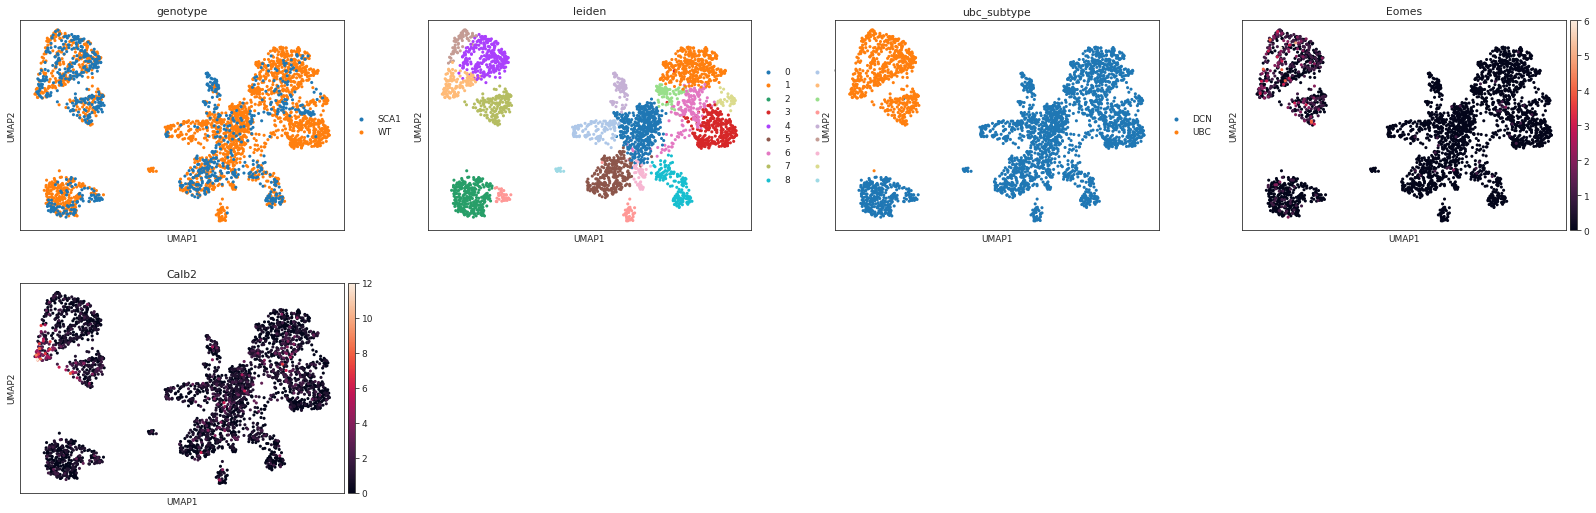

In [73]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype', 'Eomes', 'Calb2'])

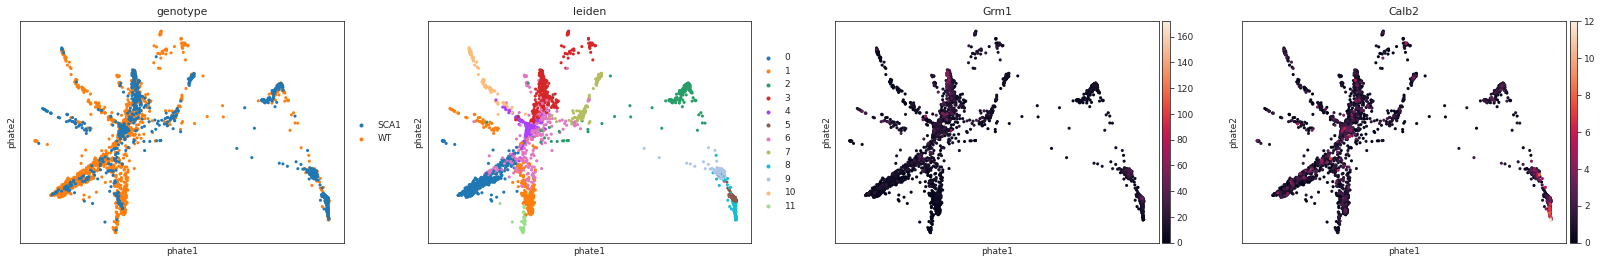

In [21]:
sc.external.tl.phate(ubc, gamma=0)
sc.external.pl.phate(ubc,  color=['genotype', 'leiden', 'Grm1', 'Calb2'])

In [46]:
goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
    'Gad1',
    'Slc6a5',
]

In [74]:
Xprime = do_magic(ubc, goi=goi, t=1)
for i in Xprime.columns:
    ubc.obs['{} (imputed)'.format(i)] = Xprime[i].values

Running MAGIC on 3154 cells and 8 genes.
Using precomputed graph and diffusion operator...


<ipython-input-45-54a92c16ff6b>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),


Calculating imputation...


/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


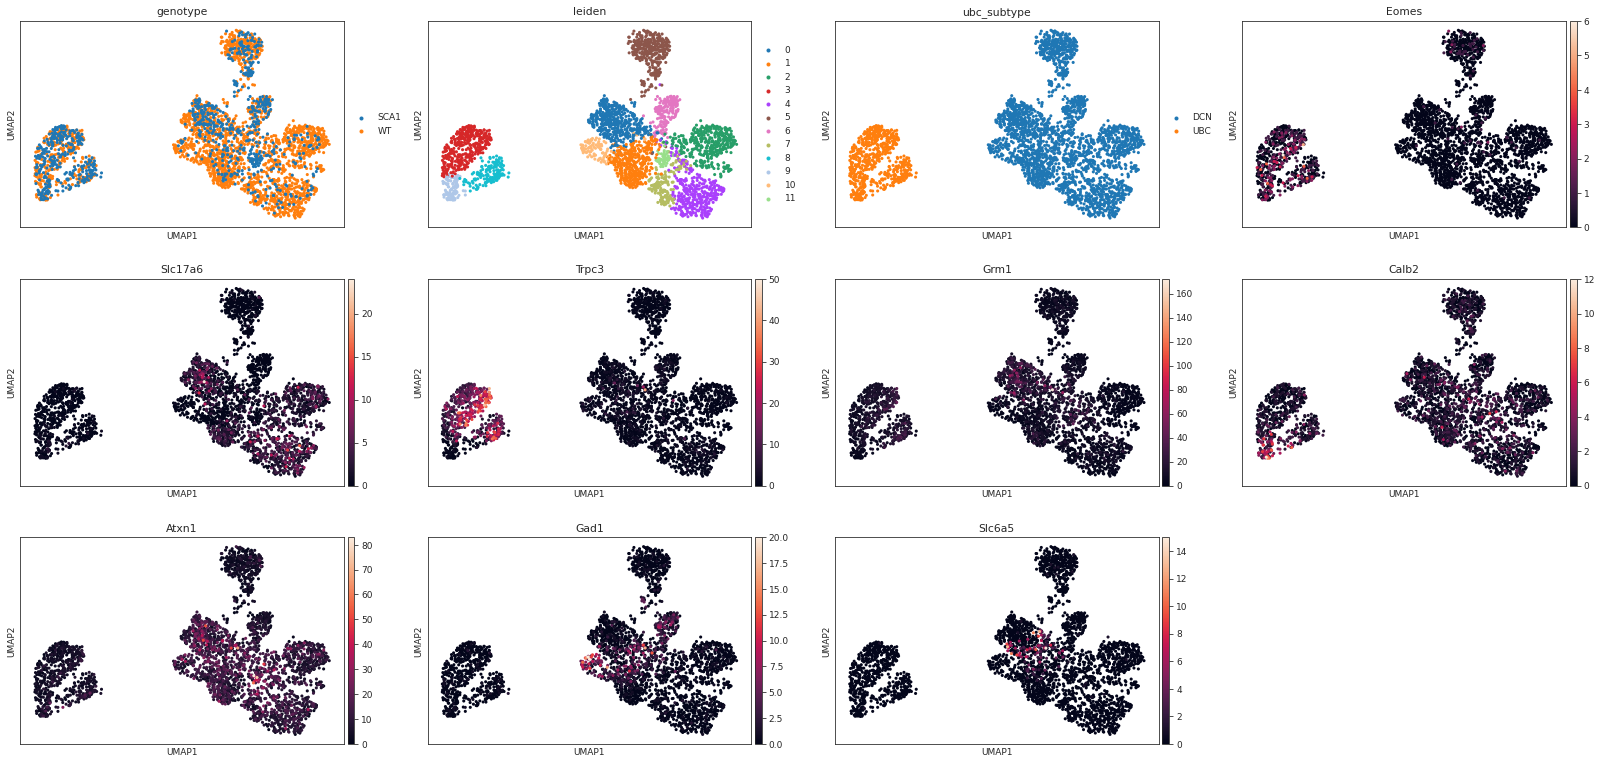

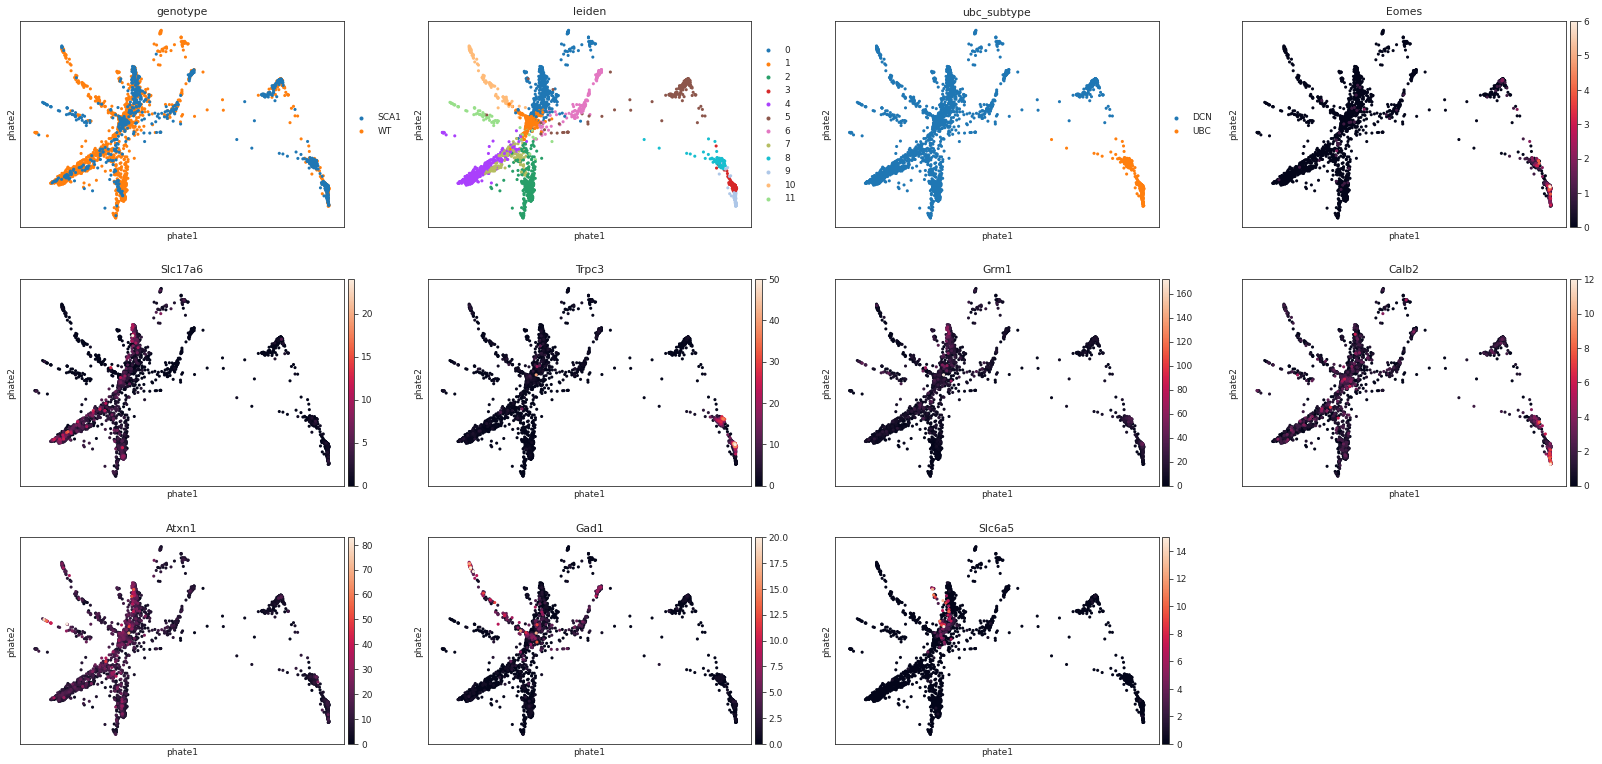

In [77]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4, save='_ubc_subclust.pdf')
sc.external.pl.phate(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4)

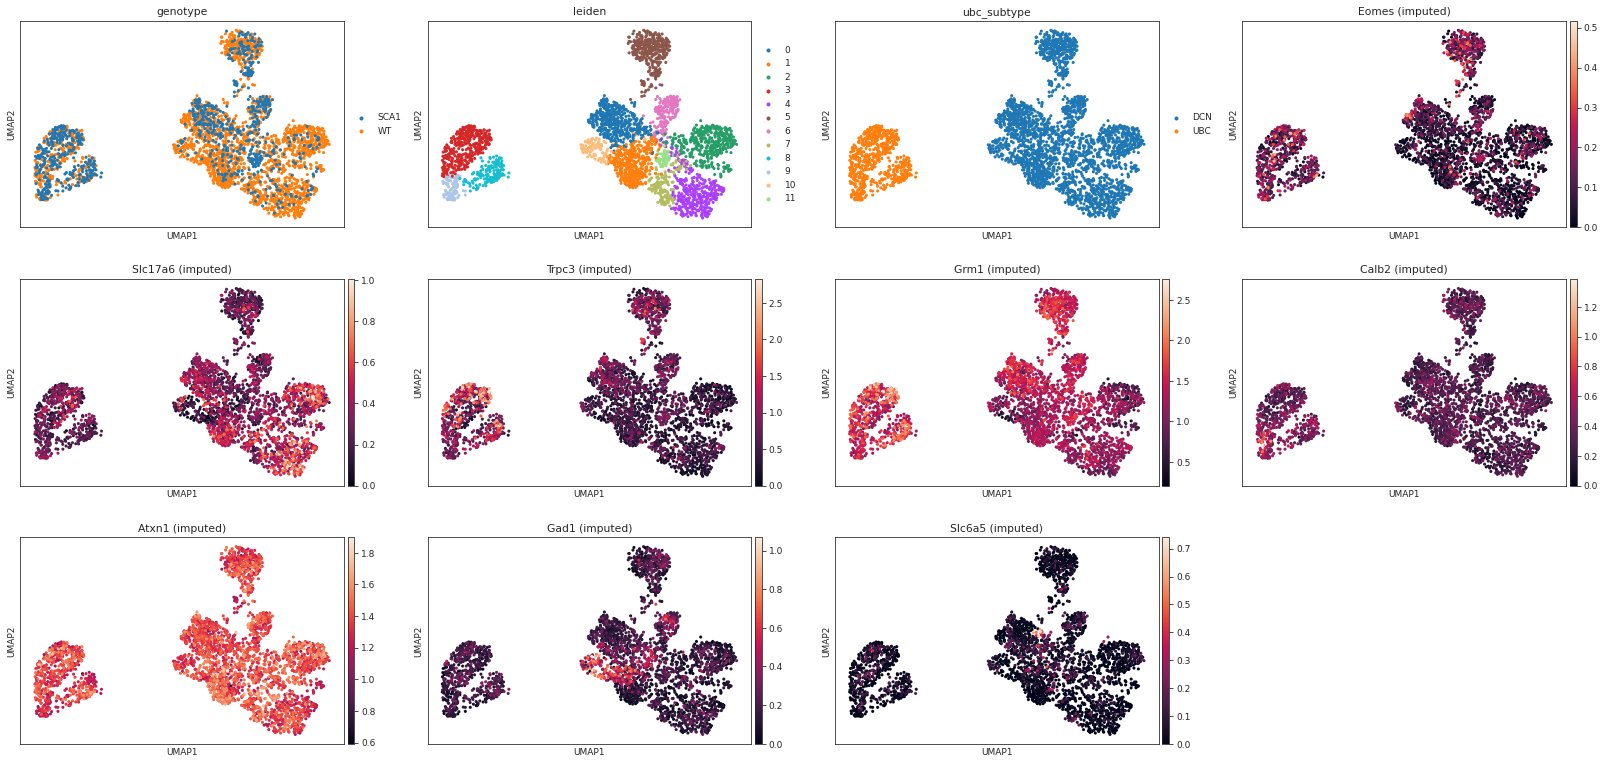

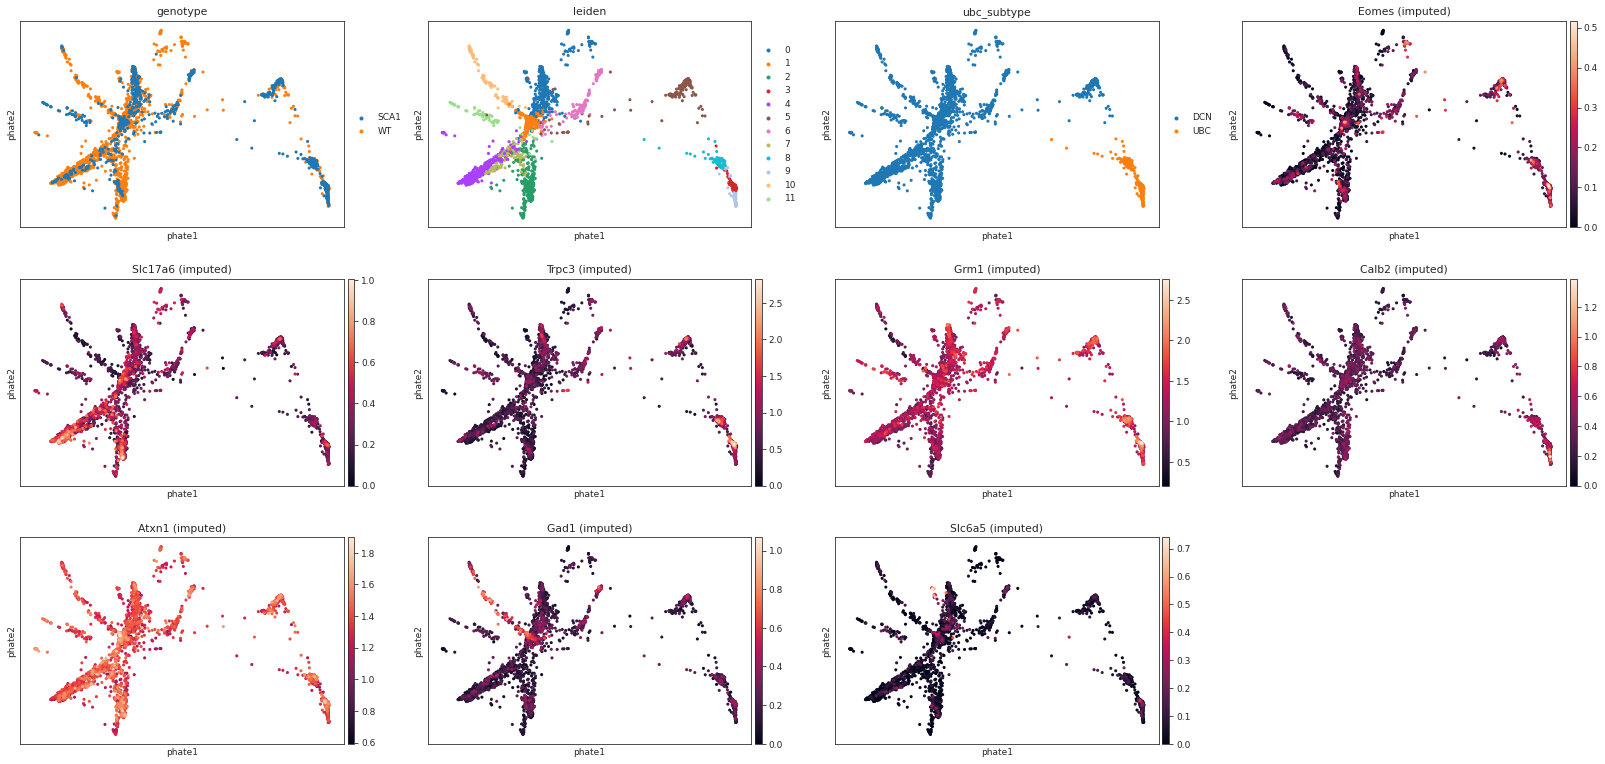

In [78]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_subclust_magic_t1.pdf')
sc.external.pl.phate(ubc, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)

In [28]:
goi = [
    'Eomes',
    'Slc17a6',
    'Trpc3',
    'Grm1',
    'Calb2',
    'Atxn1',
]

In [40]:
Xprime = do_magic(ubc, goi=goi)
for i in Xprime.columns:
    ubc.obs['{} (imputed)'.format(i)] = Xprime[i].values

Running MAGIC on 3154 cells and 6 genes.
Using precomputed graph and diffusion operator...


<ipython-input-30-155691902e4a>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),


Calculating imputation...
Calculated imputation in 0.03 seconds.


/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


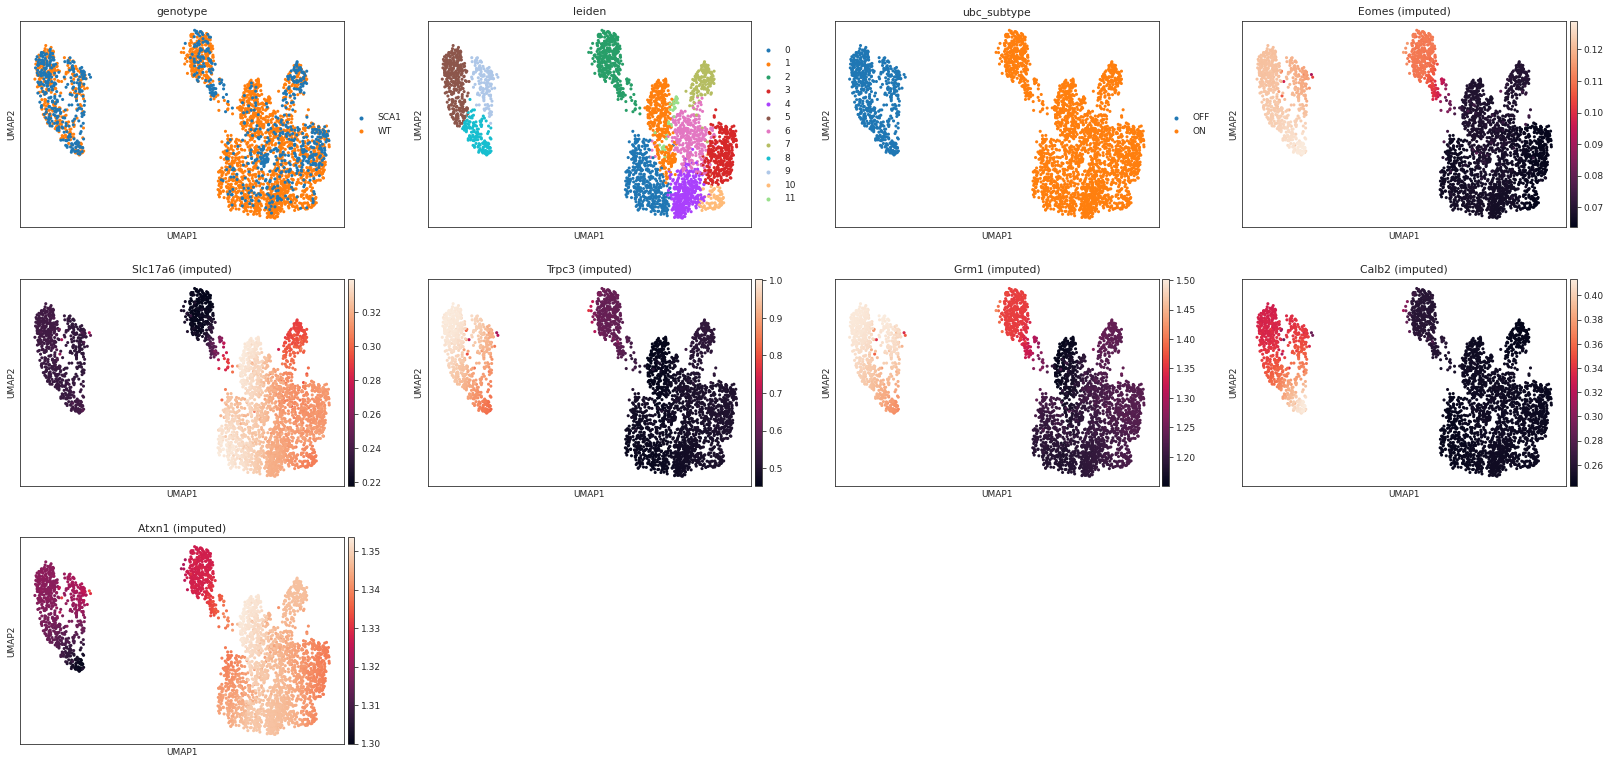

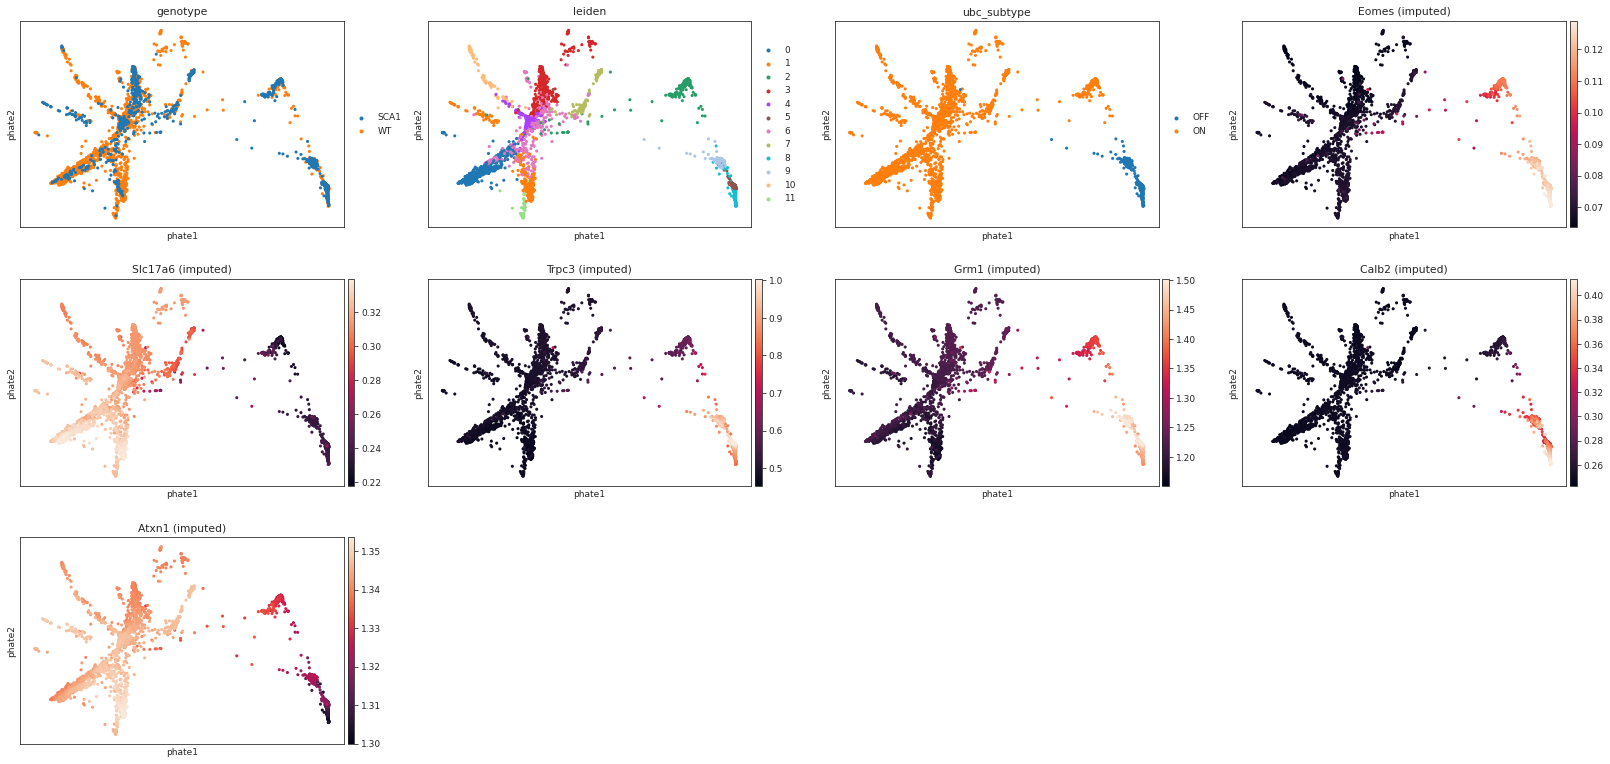

In [41]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)
sc.external.pl.phate(ubc,  color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)

In [79]:
ubc = ubc[ubc.obs['ubc_subtype']=='UBC', :]

In [91]:
!pip install scikit-misc

     |████████████████████████████████| 8.7 MB 7.1 MB/s eta 0:00:01


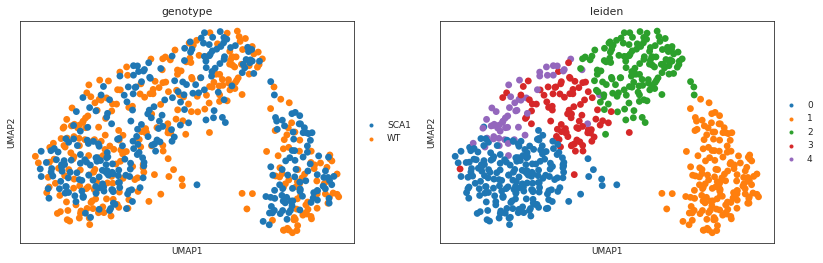

In [81]:
sc.tl.pca(ubc)
# sc.external.pp.bbknn(ubc, neighbors_within_batch=(100 // len(ubc.obs['batch'].unique())), n_pcs=50)
sc.tl.umap(ubc)
sc.tl.leiden(ubc)
sc.pl.umap(ubc, color=['genotype', 'leiden'])

In [82]:
goi

['Eomes', 'Slc17a6', 'Trpc3', 'Grm1', 'Calb2', 'Atxn1', 'Gad1', 'Slc6a5']

In [85]:
Xprime = do_magic(ubc, goi=goi, t=3)
for i in Xprime.columns:
    ubc.obs['{} (imputed)'.format(i)] = Xprime[i].values

Running MAGIC on 642 cells and 8 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


<ipython-input-84-980eef3ad985>:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


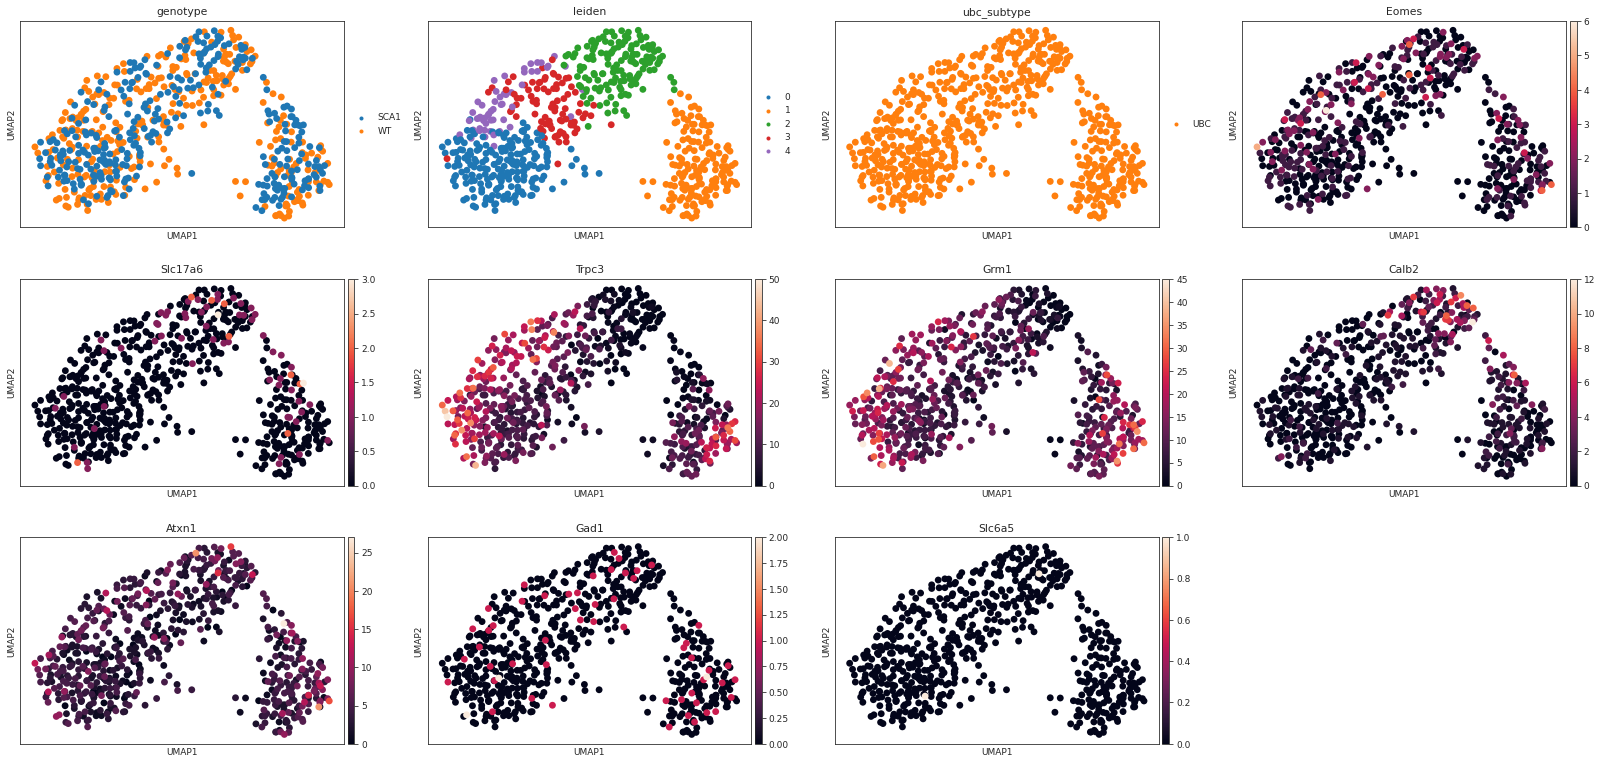

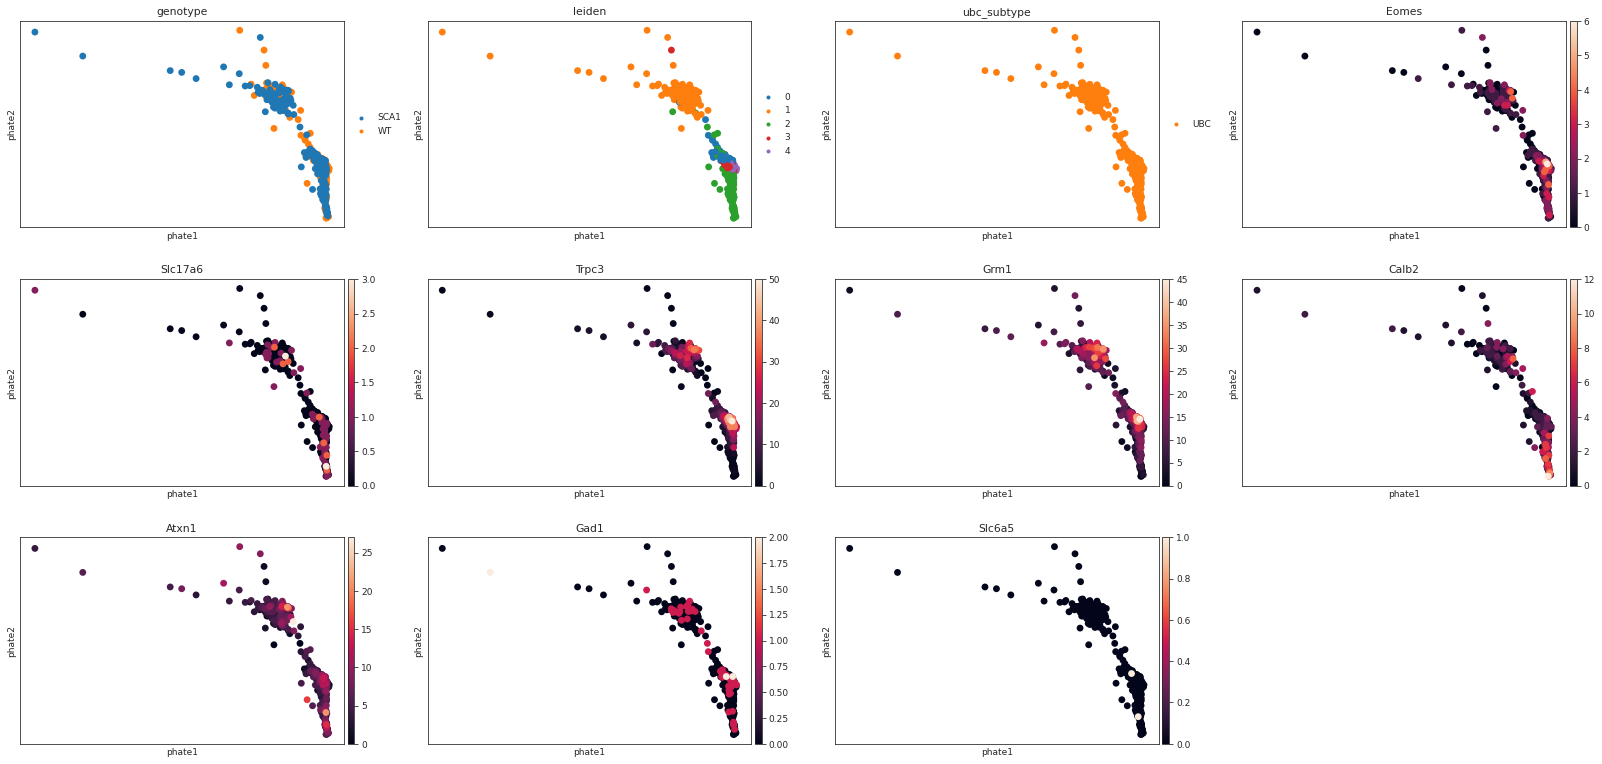

In [87]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4, save='_ubc_subclust.pdf')
sc.external.pl.phate(ubc, color=['genotype', 'leiden', 'ubc_subtype']+goi, ncols=4)

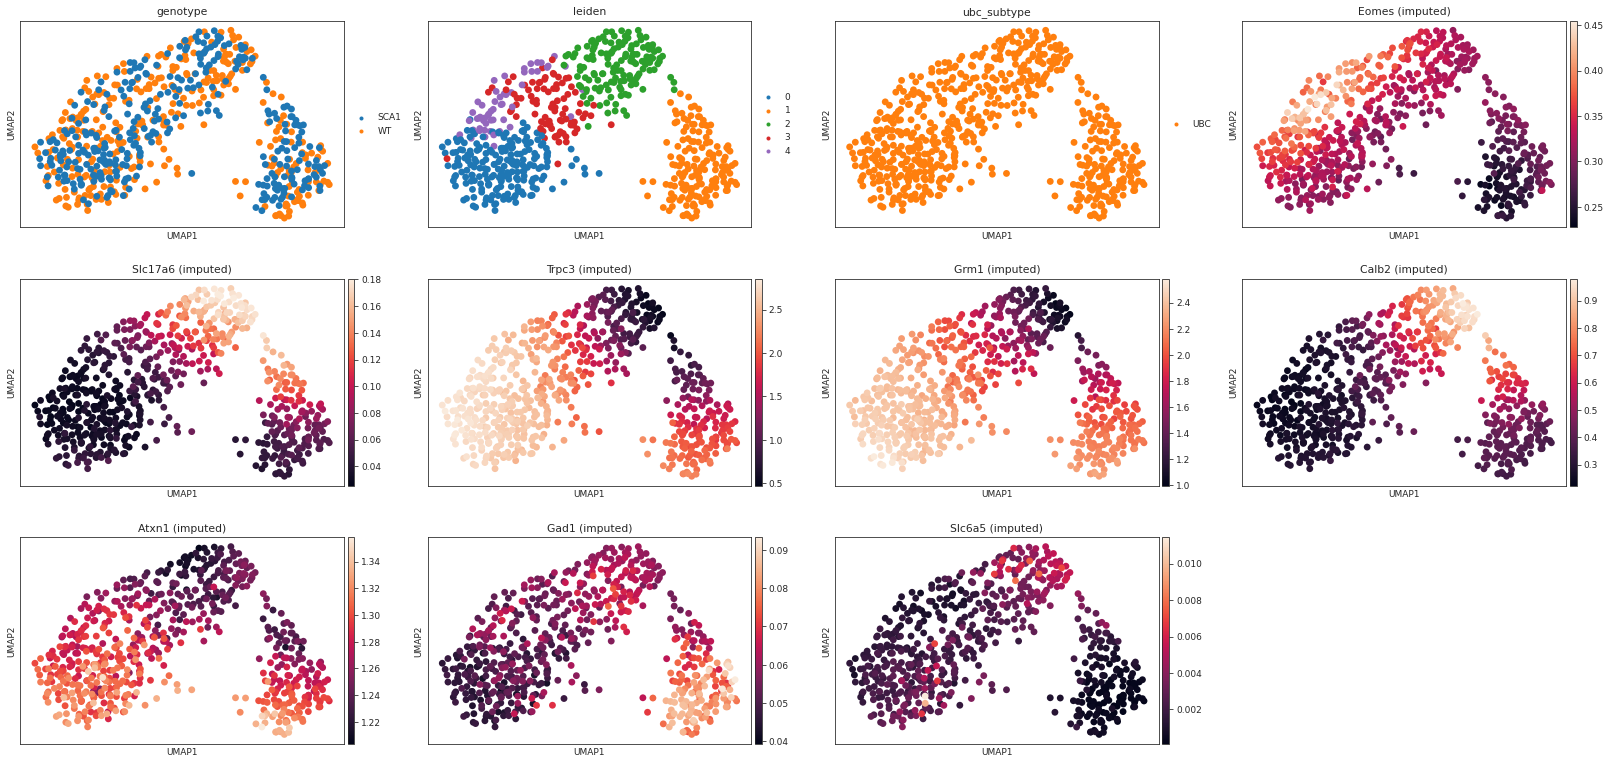

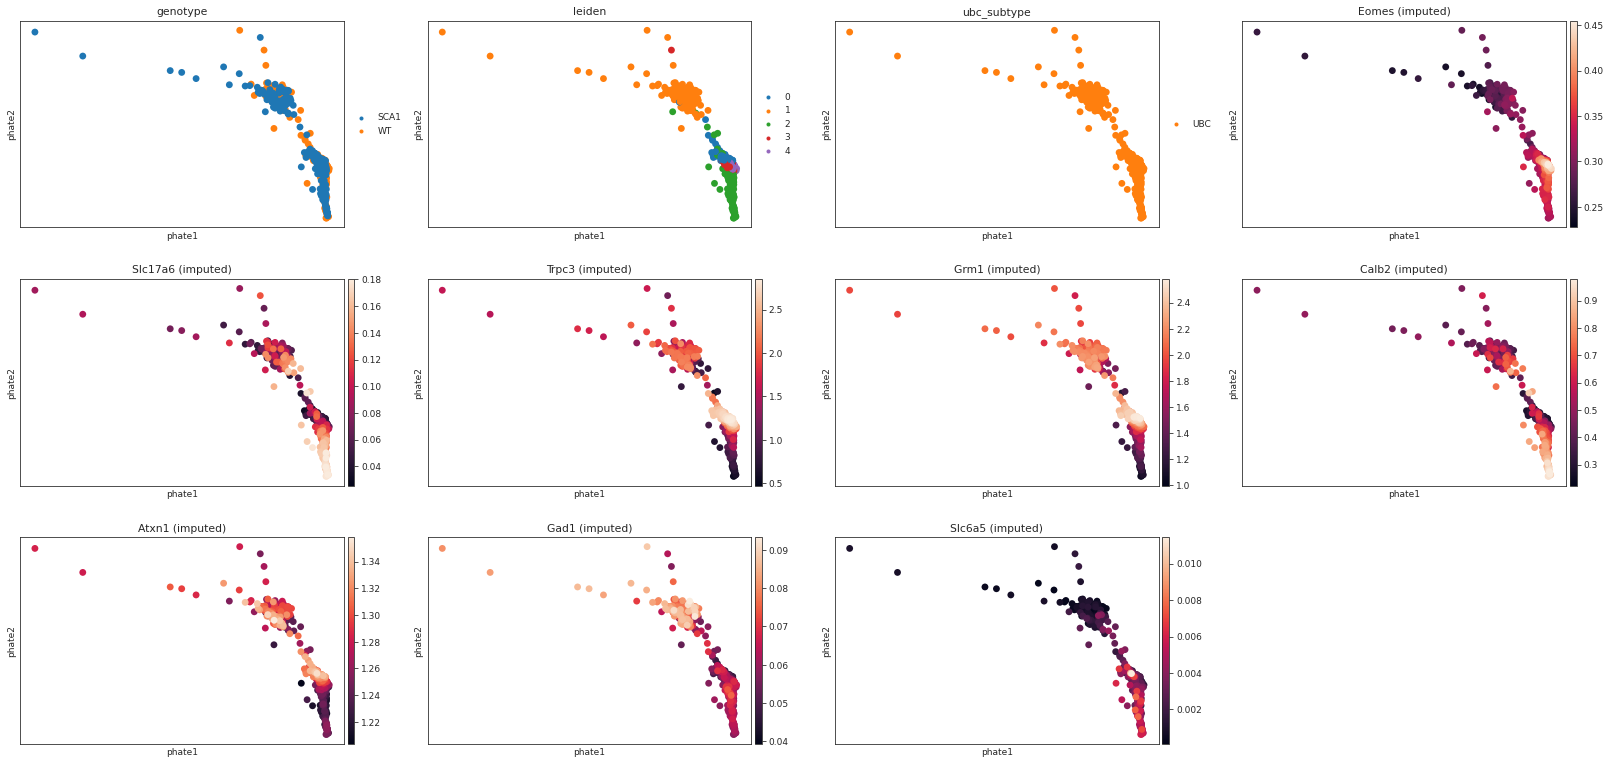

In [106]:
sc.pl.umap(ubc, color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4, save='_ubc_new_magic_t3.pdf')
sc.external.pl.phate(ubc,  color=['genotype', 'leiden', 'ubc_subtype']+['{} (imputed)'.format(i) for i in goi], ncols=4)